In [ ]:
import os
import cv2
import keras
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPool2D, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.applications import ResNet50, ResNet152, EfficientNetB0


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
labels = ['Normal', 'hemorrhagic', 'ischemic', 'nonstroke']
img_size = 224

In [3]:
def get_data(data_dir):
    x, y=[],[]
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img)) #convert BGR to RGB format
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                resized_arr = cv2.resize(img_arr, (img_size, img_size), interpolation = cv2.INTER_LINEAR) # Reshaping images to preferred size
                x.append(resized_arr)
                y.append(class_num)
            except Exception as e:
                print(e)
    return x,y

In [4]:
data_x, data_y = get_data('/kaggle/input/localdataclassification/classificationpng')
from sklearn.model_selection import train_test_split
Train_x, Val_x, Train_y, Val_y = train_test_split(data_x, data_y, test_size=0.2)

In [5]:
Train_x = np.array(Train_x)
Train_y = np.array(Train_y)
Val_x = np.array(Val_x)
Val_y = np.array(Val_y)

In [6]:
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip = True)  # randomly flip images
val_datagen= ImageDataGenerator()

In [7]:
Train_gen  = train_datagen.flow(Train_x, Train_y)
val_gen  = val_datagen.flow(Val_x, Val_y)

In [8]:
#SAMPLE IMAGE FROM TRAIN

Text(0.5, 1.0, 'ischemic')

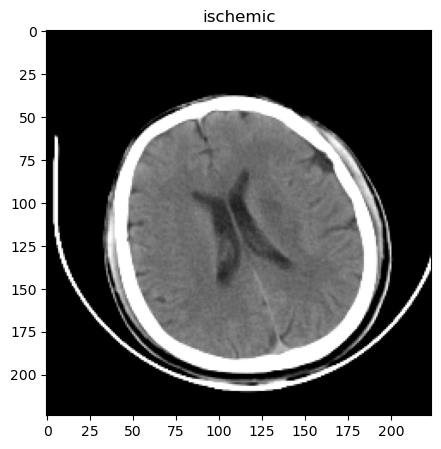

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(Train_x[0])
plt.title(labels[Train_y[0]])

In [10]:
Train_x.shape

(4484, 224, 224, 3)

In [11]:
Val_x.shape

(1121, 224, 224, 3)

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPool2D
from tensorflow.keras.applications import ResNet50, ResNet152,ResNet152V2,VGG19

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
for layer in restnet.layers:
    layer.trainable = False
counter = 0
for layer in restnet.layers:
    counter+=1
    if counter == 5:
        break
    layer.trainable = True
output = restnet.output
output = GlobalMaxPool2D()(output)
output = Dense(512, activation='relu')(output)
output = Dropout(rate=0.3)(output)
output = Dense(256, activation='relu')(output)
output = Dense(128, activation='relu')(output)
output = Dropout(rate=0.3)(output)
output = Dense(4, activation = "softmax")(output)
restnet = Model(restnet.input, output)

94765736/94765736 [==============================] - 3s 0us/step


In [13]:
optimizer = keras.optimizers.Adam(lr=0.001)
restnet.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics = ['acc'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model_path = os.path.join("/kaggle/working/", "restnet50_classifier.h5")
csv_path = os.path.join("/kaggle/working/", "restnet50_classifier.csv")

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=2),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]

In [16]:
history = restnet.fit(Train_gen,epochs=200, validation_data = val_gen)

Epoch 1/200
141/141 [==============================] - 36s 183ms/step - loss: 1.5999 - acc: 0.5239 - val_loss: 0.7755 - val_acc: 0.7092
Epoch 2/200
141/141 [==============================] - 24s 167ms/step - loss: 0.8396 - acc: 0.6684 - val_loss: 0.7719 - val_acc: 0.6887
Epoch 3/200
141/141 [==============================] - 24s 167ms/step - loss: 0.7366 - acc: 0.7112 - val_loss: 0.6114 - val_acc: 0.7752
Epoch 4/200
141/141 [==============================] - 24s 169ms/step - loss: 0.6692 - acc: 0.7429 - val_loss: 0.6226 - val_acc: 0.7618
Epoch 5/200
141/141 [==============================] - 24s 167ms/step - loss: 0.6314 - acc: 0.7616 - val_loss: 0.5368 - val_acc: 0.7993
Epoch 6/200
141/141 [==============================] - 24s 167ms/step - loss: 0.6050 - acc: 0.7656 - val_loss: 0.5584 - val_acc: 0.7939
Epoch 7/200
141/141 [==============================] - 24s 167ms/step - loss: 0.5847 - acc: 0.7756 - val_loss: 0.5828 - val_acc: 0.7743
Epoch 8/200
141/141 [===========================

In [17]:
restnet.save(model_path)

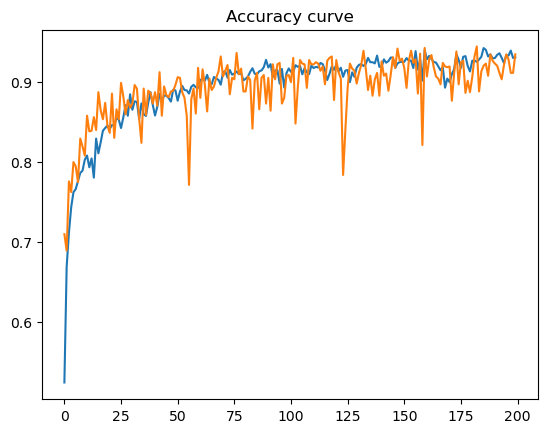

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Accuracy curve")
plt.show()

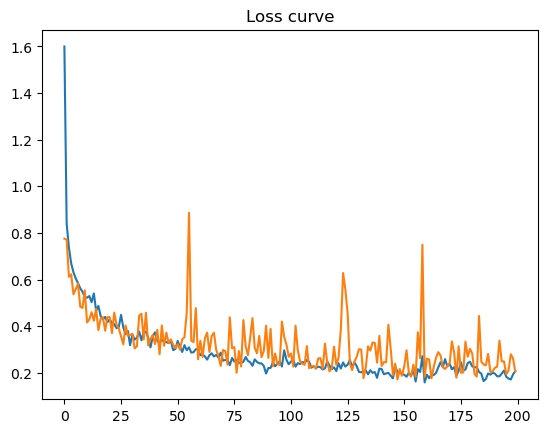

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss curve")
plt.show()

36/36 [==============================] - 3s 49ms/step


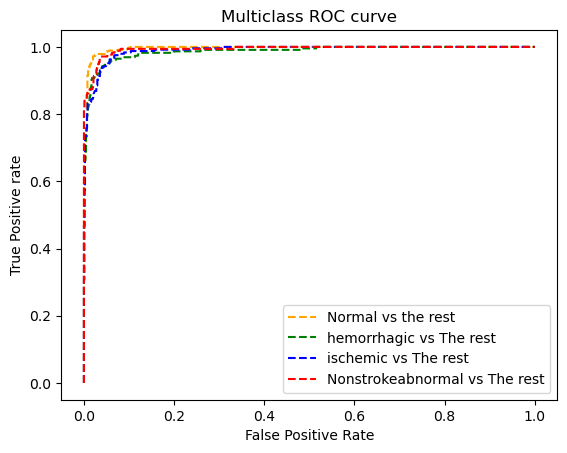

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pred_prob = restnet.predict(Val_x)
# pred_prob = restnet.predict_proba(Val_x)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(Val_y, pred_prob[:,i], pos_label=i)

# plotting    labels = ['Squamous cell carcinoma', 'Precancer', ' Normal','Adinocarcinoma']
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Normal vs the rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='hemorrhagic vs The rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='ischemic vs The rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Nonstrokeabnormal vs The rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);